In [1]:
import sys
sys.path.append('..')
import numpy as np
from src.data import jjt
from src.models.layers import MatMul, SoftmaxWithLoss, Embedding, NegativeSamplingLoss
from src.common.util import preprocess, create_contexts_target, convert_one_hot, most_similar
from src.common.trainer import Trainer
from src.common.optimizer import Adam
from src.data import jjt

In [2]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None
    

class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer0 = SoftmaxWithLoss()
        self.loss_layer1 = SoftmaxWithLoss()
        
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        score = self.out_layer.forward(h)
        l0 = self.loss_layer0.forward(score, contexts[:, 0])
        l1 = self.loss_layer1.forward(score, contexts[:, 1])
        loss = l0 + l1
        return loss
    
    def backward(self, dout=1):
        ds0 = self.loss_layer0.backward(dout)
        ds1 = self.loss_layer1.backward(dout)
        ds = ds0 + ds1
        da = self.out_layer.backward(ds)
        self.in_layer.backward(da)
        return None


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(w_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

| epoch 1 |  iter 1 / 119 | time 0[s] | loss 15.63
| epoch 1 |  iter 21 / 119 | time 0[s] | loss 15.63
| epoch 1 |  iter 41 / 119 | time 0[s] | loss 15.62
| epoch 1 |  iter 61 / 119 | time 0[s] | loss 15.59
| epoch 1 |  iter 81 / 119 | time 0[s] | loss 15.54
| epoch 1 |  iter 101 / 119 | time 0[s] | loss 15.47
| epoch 2 |  iter 1 / 119 | time 1[s] | loss 15.38
| epoch 2 |  iter 21 / 119 | time 1[s] | loss 15.21
| epoch 2 |  iter 41 / 119 | time 1[s] | loss 15.07
| epoch 2 |  iter 61 / 119 | time 1[s] | loss 14.91
| epoch 2 |  iter 81 / 119 | time 1[s] | loss 14.71
| epoch 2 |  iter 101 / 119 | time 1[s] | loss 14.50
| epoch 3 |  iter 1 / 119 | time 2[s] | loss 14.31
| epoch 3 |  iter 21 / 119 | time 2[s] | loss 14.02
| epoch 3 |  iter 41 / 119 | time 2[s] | loss 13.75
| epoch 3 |  iter 61 / 119 | time 2[s] | loss 13.47
| epoch 3 |  iter 81 / 119 | time 2[s] | loss 13.17
| epoch 3 |  iter 101 / 119 | time 2[s] | loss 13.00
| epoch 4 |  iter 1 / 119 | time 3[s] | loss 12.90
| epoch 4 |  

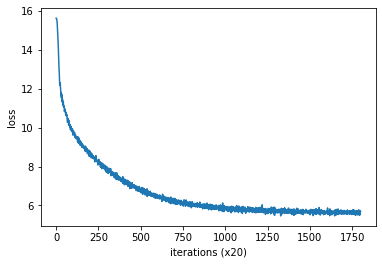

In [3]:
window_size = 1
hidden_size = 20
batch_size = 100
max_epoch = 300

corpus, word_to_id, id_to_word = jjt.load_data()

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [4]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

悪魔 [ 0.6532721  -0.87539536  0.72437674 -0.6722276   1.111228   -0.751257
  0.63425404  0.6809264   0.48989332 -0.43874806 -0.6049244   0.11508496
  0.04241449  0.809615   -0.59124595  0.48510194 -1.0866404   0.19975448
  0.6765469  -0.36977443]
の [-2.1737475   0.02537523 -0.7912883   0.5223287  -1.5431492  -1.0351442
  0.42316067  0.94020134  0.9202226   1.2447263  -2.2634492  -0.78968304
 -1.3527333   0.70760083 -0.2290059   0.56161666  0.5495967  -0.8967498
  1.2015716  -0.38947526]
笑い [-0.09074818  0.3466316   1.9648672  -1.6661379  -0.9454777  -0.886576
  1.4280052   0.7499771   0.43106785  0.7882522   0.9576737   1.1672732
  0.34640118 -0.00358379 -0.5213644  -0.00321239 -2.5805516   0.423492
  1.0528793   0.49174765]
方 [-1.020367    0.543537    1.0101197   0.43708602  0.6650936   0.00594276
 -0.20064001 -0.04630022  0.52647233  0.8925396  -0.8095087   0.9914116
  0.67890567  1.5854206  -1.2725958  -0.3447327   1.5063673   0.18078901
  0.69002163 -1.6994348 ]
せい [-0.12773047 -0.4

In [5]:
query = '奴'
most_similar(query, word_to_id, id_to_word, word_vecs)


[query] 奴
 売れ: 0.6941988468170166
 タイプ: 0.6878275871276855
 わだかまり: 0.6631020903587341
 かっ: 0.6557588577270508
 ボディーガード: 0.6396226286888123
